In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

%matplotlib inline
from IPython.display import HTML

In [2]:
class DataStore():
    def __init__(self):
        
        print('Loading data...')
        t1 = time.time()
        
        self.car_fnames = glob.glob('images/vehicles/*/*.png')
        self.scn_fnames = glob.glob('images/non-vehicles/*/*.png')
        self.car_images = [mpimg.imread(fname) for fname in self.car_fnames]
        self.scn_images = [mpimg.imread(fname) for fname in self.scn_fnames]

        t2 = time.time()
        print('Loaded all data in {} seconds'.format(round(t2-t1), 2))

        
ds = DataStore()

Loading data...
Loaded all data in 47 seconds


In [34]:
def cvt_color(img, color_space):
    if color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(img)

    
def draw_boxes(img, boxes, color=(255,0,0), thick=6):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thick)
    return imcopy


class VehicleDetection():
    
    
    def __init__(self, data_store, color_space):
        self.data_store = data_store
        self.color_space = color_space
        self.orientations = 9
        self.pixels_per_cell = 8
        self.cells_per_block = 2
        self.channel_idxs = [0,1,2]
        self.threshold=2
        self.scale_configs = [
            {'scale':1.0, 'ystart':400, 'ystop':500},
            {'scale':1.2, 'ystart':400, 'ystop':550},
            {'scale':1.5, 'ystart':400, 'ystop':650},
            {'scale':2.0, 'ystart':400, 'ystop':650},
        ]
        self.use_queue=False
        self.boxes_queue = []
        self.queue_frames = 4

        
    def get_hog(self, img, feature_vector=False, visualise=False):
        return hog(img,
                   orientations=self.orientations,
                   pixels_per_cell=(self.pixels_per_cell, self.pixels_per_cell),
                   cells_per_block=(self.cells_per_block, self.cells_per_block),
                   transform_sqrt=True,
                   visualise=visualise,
                   feature_vector=feature_vector)

    
    # Assumes img is color-converted
    def find_boxes(self,
                   img,
                   ystart, ystop, scale,
                   svc=None,
                   scaler=None,
                   window=64,
                   cells_per_step=1):
        
        if not svc:
            svc = self.svc
        if not scaler:
            scaler = self.scaler
        
        # Crop and re-size image
        img = img[ystart:ystop,:,:]
        if scale != 1:
            img = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)))
    
        # Calculate window constants
        nx_cells = img.shape[1] // self.pixels_per_cell - 1
        ny_cells = img.shape[0] // self.pixels_per_cell - 1
    
        cells_per_window = window // self.pixels_per_cell - 1
    
        nx_steps = (nx_cells - cells_per_window) // cells_per_step
        ny_steps = (ny_cells - cells_per_window) // cells_per_step
    
        # Calculate hogs
        hogs = [self.get_hog(img[:,:,ch_idx]) for ch_idx in self.channel_idxs]
    
        # Calculate boxes
        hot_boxes = []
        for nx_step in range(nx_steps):
            for ny_step in range(ny_steps):
            
                ypos = ny_step * cells_per_step
                xpos = nx_step * cells_per_step
            
                hog_features = [hog[ypos:ypos+cells_per_window, xpos:xpos+cells_per_window].ravel() for hog in hogs]
                hog_features = np.hstack(hog_features)
            
                prediction = svc.predict(scaler.transform(hog_features))
                if prediction == 1:
                    x_l = xpos * self.pixels_per_cell
                    y_t = ypos * self.pixels_per_cell
                    box_l = np.int(x_l * scale)
                    box_t = np.int(y_t * scale + ystart)
                    offset = np.int(window * scale)
                    box = ((box_l, box_t), (box_l+offset, box_t+offset))
                    hot_boxes.append(box)
    
        return hot_boxes

    
    def find_boxes_with_scales(self,
                               img,
                               ystart, ystop, scales,
                               svc=None,
                               scaler=None,
                               window=64,
                               cells_per_step=1,
                               verbose=False):
        boxes = []
        for scale in scales:
            new_boxes = self.find_boxes(img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, scaler=scaler, window=window, cells_per_step=cells_per_step)
            if verbose:
                print('Found {} boxes using scale {}'.format(len(new_boxes), scale))
            boxes += new_boxes
        return boxes
    
    
    def draw_boxes_using_heatmap(self, img, boxes, threshold=None):
        if threshold is None:
            threshold = self.threshold
        # Build heatmap from boxes
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for box in boxes:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heatmap[heatmap <= threshold] = 0
        #heatmap = np.clip(heatmap, 0, 255)
        # Draw thresholded boxes on original image
        draw_img = np.copy(img)
        labels = label(heatmap)
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
        return draw_img, heatmap, labels
    
    
    def train(self):
        t1 = time.time()
        print('Extracting features and training classifer...')
        
        car_features = []
        for img in self.data_store.car_images:
            img = cvt_color(img, self.color_space)
            img_features = np.concatenate([self.get_hog(img[:,:,ch_idx], feature_vector=True) for ch_idx in self.channel_idxs])
            car_features.append(img_features)
            
        scn_features = []
        for img in self.data_store.scn_images:
            img = cvt_color(img, self.color_space)
            img_features = np.concatenate([self.get_hog(img[:,:,ch_idx], feature_vector=True) for ch_idx in self.channel_idxs])
            scn_features.append(img_features)

        t2 = time.time()
        print('Extracted all features in {} seconds'.format(round(t2-t1)))
            
        unscaled_X = np.vstack((car_features, scn_features)).astype(np.float64)
        self.scaler = StandardScaler().fit(unscaled_X)
        
        X = self.scaler.transform(unscaled_X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(scn_features))))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))
        self.svc = LinearSVC()
        self.svc.fit(X_train, y_train)
        score = self.svc.score(X_test, y_test)

        
        t3 = time.time()
        print('Trained classifier in {} seconds with accuracy {}'.format(round(t2-t1), round(score, 4)))

        
    def process_img(self, img, threshold=None):
        img_orig = np.copy(img)
        img = cvt_color(img, self.color_space)
        
        boxes = []
        for cfg in self.scale_configs:
            boxes += self.find_boxes_with_scales(img, ystart=cfg['ystart'], ystop=cfg['ystop'], scales=[cfg['scale']])
        use_boxes = boxes[:]
        
        # Process boxes queue
        if self.use_queue:
            if len(self.boxes_queue) >= self.queue_frames:
                self.boxes_queue = self.boxes_queue[1:]
            for old_boxes in self.boxes_queue:
                use_boxes.extend(old_boxes)
            self.boxes_queue.append(boxes)
            
        img, _ = vd.draw_boxes_using_heatmap(img_orig, use_boxes, threshold=threshold)
        return img

In [35]:
vd = VehicleDetection(ds, 'YCrCb')
vd.train()

Extracting features and training classifer...
Extracted all features in 60 seconds
Trained classifier in 60 seconds with accuracy 0.9803


Found 6 boxes using scale 0.8
Found 5 boxes using scale 1
Found 6 boxes using scale 1.2
Found 10 boxes using scale 1.5
Found 9 boxes using scale 1.8
Found 3 boxes using scale 2.0
Found 39 boxes


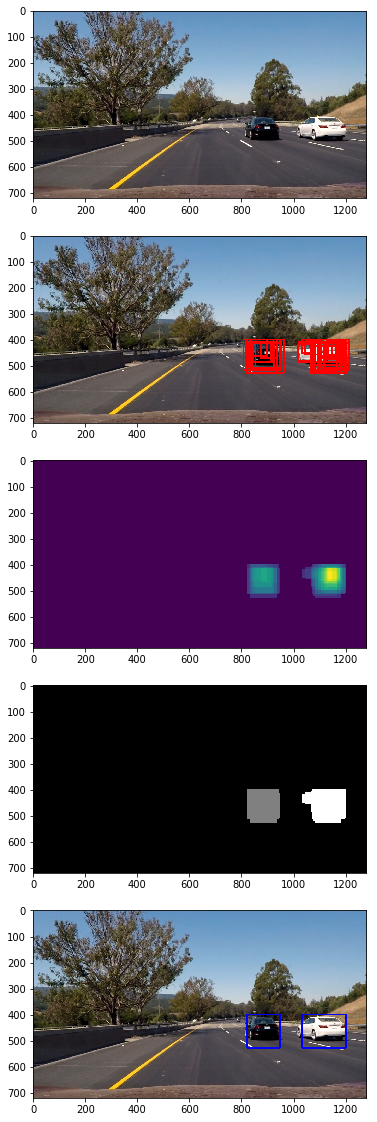

In [38]:
img_orig = mpimg.imread('test_images/test6.jpg')
img = cvt_color(img_orig, 'YCrCb')
scales = [0.8, 1, 1.2, 1.5, 1.8, 2.0]
boxes = vd.find_boxes_with_scales(img, ystart=400, ystop=700, scales=scales, verbose=True)
img, heatmap, labels = vd.draw_boxes_using_heatmap(img_orig, boxes, threshold=2)
print('Found {} boxes'.format(len(boxes)))
fig = plt.figure(figsize=(8, 20))
plot = fig.add_subplot(5,1,1)
plot.imshow(img_orig)
plot = fig.add_subplot(5,1,2)
plot.imshow(draw_boxes(img_orig, boxes))
plot = fig.add_subplot(5,1,3)
plot.imshow(heatmap)
plot = fig.add_subplot(5,1,4)
plot.imshow(labels[0], cmap='gray')
plot = fig.add_subplot(5,1,5)
plot.imshow(img)
fig.savefig('output_images/test6_pipeline.jpg')


In [9]:
vd.use_queue = True
clip = VideoFileClip('test_video.mp4').fl_image(vd.process_img)
%time clip.write_videofile('test_output.mp4', audio=False)
HTML("""
<video width="640" height="480" controls>
  <source src="test_output.mp4" type="video/mp4">
</video>
""")

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:39<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 39 s, sys: 1.45 s, total: 40.4 s
Wall time: 40.9 s


In [ ]:
vd.use_queue = True
clip = VideoFileClip('project_video.mp4').fl_image(vd.process_img)
%time clip.write_videofile('output.mp4', audio=False)
HTML("""
<video width="640" height="480" controls>
  <source src="output.mp4" type="video/mp4">
</video>
""")

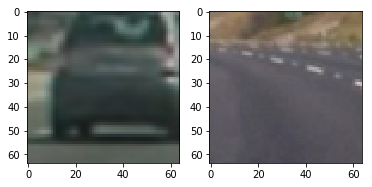

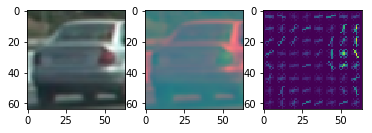

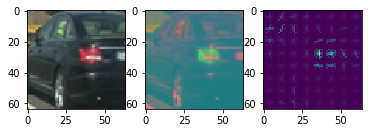

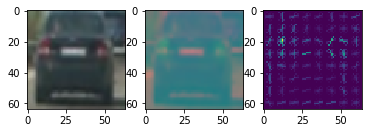

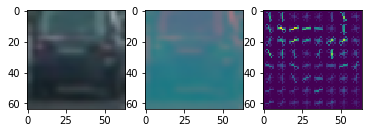

In [39]:
fig = plt.figure()
plot = fig.add_subplot(1,2,1)
plot.imshow(ds.car_images[50])
plot = fig.add_subplot(1,2,2)
plot.imshow(ds.scn_images[50])
fig.savefig('output_images/car_not_car.jpg')

fnames = [
    'images/vehicles/GTI_Left/image0009.png',
    'images/vehicles/GTI_Right/image0001.png',
    'images/vehicles/GTI_MiddleClose/image0001.png',
    'images/vehicles/GTI_Far/image0015.png'
]
for i in range(len(fnames)):
    img_orig = mpimg.imread(fnames[i])
    img = cvt_color(img_orig, vd.color_space)
    _, hog_img = vd.get_hog(img[:,:,1], visualise=True)
    fig = plt.figure()
    plot = fig.add_subplot(1,3,1)
    plot.imshow(img_orig)
    plot = fig.add_subplot(1,3,2)
    plot.imshow(img)
    plot = fig.add_subplot(1,3,3)
    plot.imshow(hog_img)
    fig.savefig('output_images/hog_example_{}.jpg'.format(i))

